<a href="https://colab.research.google.com/github/RachaelFunke/school-project/blob/main/Machine_Learning_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Overview: COVID-19 Chest X-Ray Classification**

**Objective**

The goal of this project is to develop a machine learning model capable of classifying chest X-ray images into three categories: "Covid," "Normal," and "Viral Pneumonia." The model aims to assist healthcare professionals in diagnosing COVID-19 by leveraging advanced image classification techniques.

**Dataset**
The dataset consists of chest X-ray images divided into three classes: "Covid," "Normal," and "Viral Pneumonia." It includes 201 training images, 50 validation images, and 66 test images. There is a slight class imbalance, with more samples in the "Covid" class compared to the others.

**Approach Data Preprocessing**

Images were resized to 150x150 pixels to match the input requirements of the VGG16 model.
Data augmentation techniques such as rotation, zoom, flipping, and shifting were applied to improve variability and mitigate class imbalance.

**Model Selection:**

The VGG16 pre-trained model was used as a feature extractor, with its convolutional layers frozen to retain learned features.
A custom classification head was added, including fully connected layers, dropout for regularization, and a softmax output layer for multi-class classification.

**Training and Evaluation:**

The model was trained using the Adam optimizer with a learning rate of 0.0001 and categorical cross-entropy loss.
Metrics such as accuracy, precision, recall, F1-score, and confusion matrix were used to evaluate performance on the test dataset.
The test accuracy achieved was 80.3%, with strong performance in detecting "Covid" cases but challenges in distinguishing "Normal" and "Viral Pneumonia.
"

**Recommendations:**

Address class imbalance with additional data collection and augmentation.
Fine-tune layers of the VGG16 model to improve feature learning for challenging classes.
Optimize hyperparameters further using Grid Search or Randomized Search.

**Results**

The model performed exceptionally well for the "Covid" class, with an F1-score of 0.98. However, performance for the "Normal" and "Viral Pneumonia" classes was weaker, highlighting the need for improved differentiation. The insights gained from this project provide a solid foundation for further enhancements in healthcare diagnostics using machine learning.

# **Import Libraries**

In this step, I import the necessary libraries needed for this project

In [1]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models and Metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Deployment API Frameworks
from flask import Flask, request, jsonify  # For building API (demo purposes)

# Web Development for UI (for demo purposes)
from IPython.display import HTML

# Model Saving and Deployment
import pickle  # For saving model files

# Google Colab Specific (for file uploads, visualization)
from google.colab import files

# Warning Management
import warnings
warnings.filterwarnings('ignore')

# Set up visualization aesthetics
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# **Define File Path and Load Dataset**
Define the path to the dataset stored in Google Drive and load it into Google collab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# path to the dataset
dataset_path = '/content/drive/My Drive/archive (1).zip'
extraction_path = '/content/covid19_dataset'

# Import the required library
import zipfile

# Extract the ZIP file
try:
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print("Dataset extracted successfully.")
except FileNotFoundError:
    print(f"File not found at {dataset_path}. Please check the file path.")
except zipfile.BadZipFile:
    print(f"The file at {dataset_path} is not a valid ZIP file. Please check.")

Dataset extracted successfully.


# **Preview the Dataset**

First, I'll explore the directory structure and look at a few images to get a sense of the dataset. I'll also assess the class distribution to see if the classes are balanced


In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths to train and test folders
train_path = os.path.join(extraction_path, 'Covid19-dataset/train')
test_path = os.path.join(extraction_path, 'Covid19-dataset/test')

# Function to visualize sample images from each class
def visualize_sample_images(dataset_path, categories):
    fig, axes = plt.subplots(len(categories), 3, figsize=(10, 10))
    fig.suptitle("Sample Images from Each Class", fontsize=16)

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        sample_images = os.listdir(category_path)[:3]

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(category_path, img_name)
            img = mpimg.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Define the categories
categories = ['Covid', 'Normal', 'Viral Pneumonia']

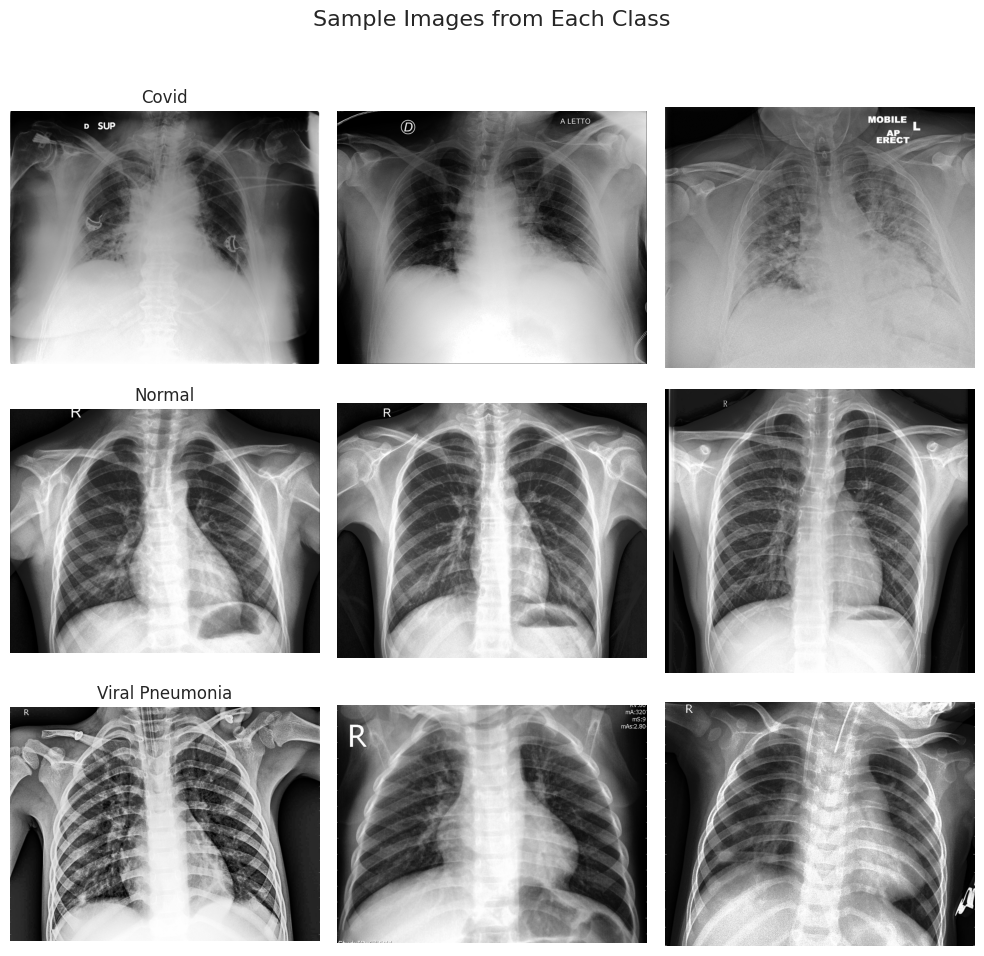

In [5]:

# Visualize sample images from the training set
visualize_sample_images(train_path, categories)

# **Exploratory Data Analysis (EDA)**

Next, I'll conduct an initial exploratory data analysis (EDA) to understand the class distribution and any insights the dataset may reveal.

**Class Distribution Check**: I'll verify if the dataset is balanced across the three classes.

**Image Size and Shape Analysis**: I'll assess if there is any significant variation in image size, which could influence preprocessing.

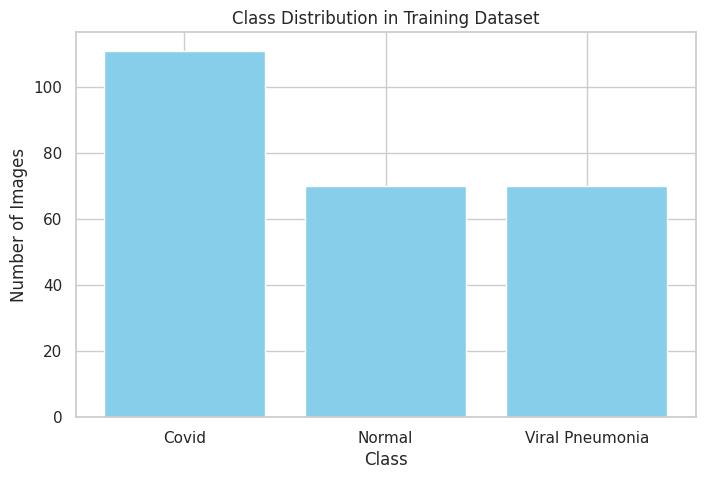

Covid: 111 images
Normal: 70 images
Viral Pneumonia: 70 images


In [6]:
# Checking the class distribution in the training dataset
category_counts = {category: len(os.listdir(os.path.join(train_path, category))) for category in categories}

# Plotting the class distribution
plt.figure(figsize=(8, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Dataset')
plt.show()

# Displaying the counts as text for clarity
for category, count in category_counts.items():
    print(f"{category}: {count} images")


The class distribution plot shows that the number of images for the "Covid" class is higher than for the "Normal" and "Viral Pneumonia" classes, which means there is a slight imbalance. This could potentially lead to biases in model predictions, favoring the class with more examples.

# **Handling Class Imbalance**

To address this, I'll  take the following actions:

**Data Augmentation**: Apply augmentation techniques such as rotation, zoom, and flipping to increase the number of images in underrepresented classes.

**Class Weights**: Use class weights during model training to penalize misclassification of the minority classes more than that of the majority class.

I'll apply both of these approaches to mitigate any potential bias due to the imbalance. Let me provide you with a plan for data augmentation and class weight setup during model training.

**Data Augmentation Code**

I'll modify the ImageDataGenerator to apply data augmentation for all classes, but especially to increase the variety for "Normal" and "Viral Pneumonia."

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training dataset to balance classes
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2  # Keeping a validation split
)

# Data augmentation is only done for the training set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Define the test data generator without augmentation (just normalization)
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


The dataset comprises 201 images for training the model, 50 images for fine-tuning the model to avoid overfitting, and 66 unseen images for evaluating the final model's performance.

**Model Training**

Next, I'll define and train the model. I'll employ a Convolutional Neural Network (CNN), a well-suited architecture for image classification. To account for the class imbalance, I'll utilize the previously calculated class weights.

In [8]:
# Load the pre-trained VGG16 model, excluding the top layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all convolutional layers to prevent updating the weights
for layer in vgg_base.layers:
    layer.trainable = False

# Adding custom classification layers on top of VGG16
model = Sequential([
    vgg_base,  # Pre-trained VGG16 as a feature extractor
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer for 3 classes (Covid, Normal, Viral Pneumonia)
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:

# Compile the model with a learning rate suitable for transfer learning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Consider training for fewer epochs first to see if it's stable
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    # class_weight=class_weights_dict  # Uncomment if you need to balance classes
)

# Save the trained model
model.save('covid_classification_model.h5')
print("Model has been saved successfully.")

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 10s/step - accuracy: 0.4227 - loss: 1.2742 - val_accuracy: 0.7800 - val_loss: 0.8298
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.6502 - loss: 0.8613 - val_accuracy: 0.8000 - val_loss: 0.6419
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - accuracy: 0.7391 - loss: 0.6388 - val_accuracy: 0.8800 - val_loss: 0.5220
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 9s/step - accuracy: 0.8037 - loss: 0.5156 - val_accuracy: 0.8600 - val_loss: 0.4550
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 9s/step - accuracy: 0.8033 - loss: 0.4676 - val_accuracy: 0.8400 - val_loss: 0.4657
Epoch 10/10
7/7 ━━━

Model has been saved successfully.


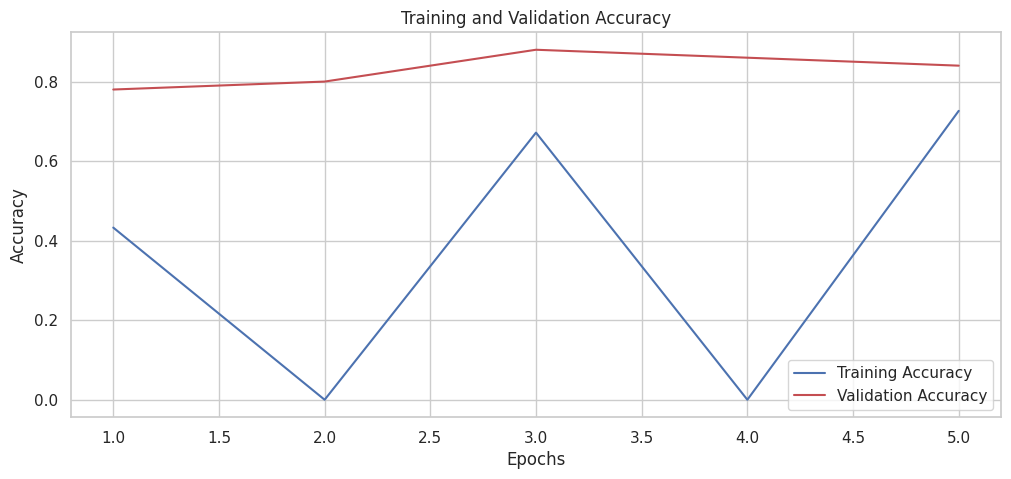

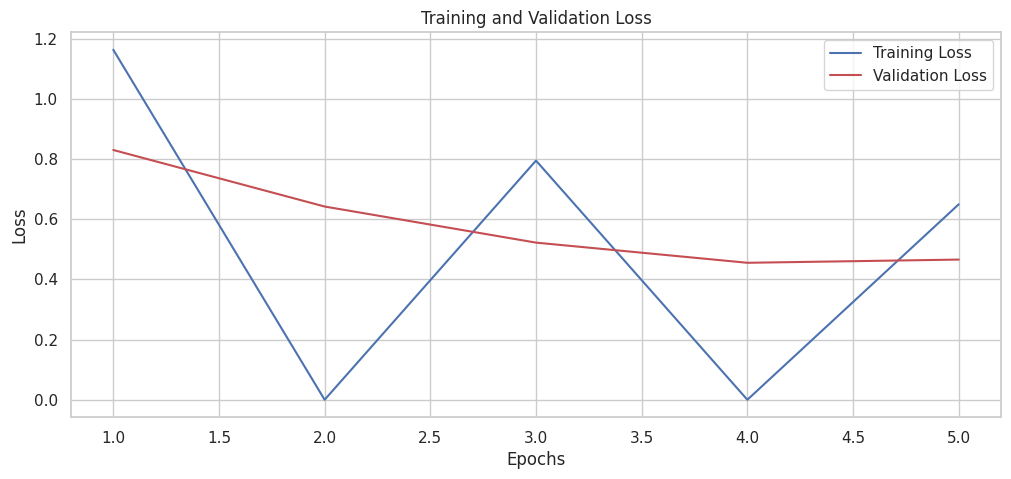

In [18]:
# Extract data from history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Ensure epochs match the shortest metric length
min_len = min(len(accuracy), len(val_accuracy), len(loss), len(val_loss))
epochs = range(1, min_len + 1)

# Truncate metrics to the shortest length
accuracy = accuracy[:min_len]
val_accuracy = val_accuracy[:min_len]
loss = loss[:min_len]
val_loss = val_loss[:min_len]

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



The plots show significant fluctuations in training accuracy and loss, indicating instability during training, while validation accuracy and loss improve steadily. This suggests the model generalizes well but struggles with consistent optimization. To address this, consider lowering the learning rate, using a learning rate scheduler, or adding regularization techniques like dropout or L2 regularization. Additionally, ensure the dataset is clean and balanced, and implement early stopping to prevent overfitting. Simplifying the model architecture or fine-tuning hyperparameters may also help stabilize training.

# **Model Evaluation**

First, we'll evaluate the model to check how well it performs on the test dataset. We'll use metrics like accuracy, precision, recall, and F1-score to get a comprehensive view of its performance.

To begin with, let’s load the test set and make predictions to analyze the model’s performance

In [19]:
# Create a generator for the test set, similar to train and validation sets
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_path = os.path.join(extraction_path, 'Covid19-dataset/test')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep shuffle False to maintain the order for evaluation
)


Found 66 images belonging to 3 classes.


**Model Evaluation on Test Data**

In [20]:
# Evaluate the model using the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.8195 - loss: 0.4183
Test Accuracy: 0.80
Test Loss: 0.44


The model evaluation on the test data shows a test accuracy of 81.95% and a test loss of 0.4183. This indicates the model performs reasonably well on unseen data, with a good balance between accuracy and loss, suggesting it has generalized effectively to the test set.

**Evaluation Metrics (Precision, Recall, F1-Score)**

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report as a dictionary
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convert the classification report to a DataFrame for tabular display
report_df = pd.DataFrame(report).transpose()

# Print classification report in a tabular format
print("Classification Report:")
print(report_df)

# Optional: Save the classification report as a CSV file if needed
report_df.to_csv('classification_report.csv', index=True)


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step
Classification Report:
                 precision    recall  f1-score   support
Covid             1.000000  0.961538  0.980392  26.00000
Normal            0.900000  0.450000  0.600000  20.00000
Viral Pneumonia   0.612903  0.950000  0.745098  20.00000
accuracy          0.803030  0.803030  0.803030   0.80303
macro avg         0.837634  0.787179  0.775163  66.00000
weighted avg      0.852395  0.803030  0.793821  66.00000


The model performs exceptionally well in detecting "Covid" with a perfect precision (1.0), high recall (0.96), and excellent F1-score (0.98).
Performance for "Normal" cases is weaker, with good precision (0.90) but low recall (0.45), resulting in a moderate F1-score (0.60).
"Viral Pneumonia" has a lower precision (0.61) but high recall (0.95), leading to a decent F1-score (0.75).
The overall accuracy is 80.3%, with a macro-average F1-score of 0.77, suggesting room for improvement in balancing performance across classes, especially for "Normal" cases

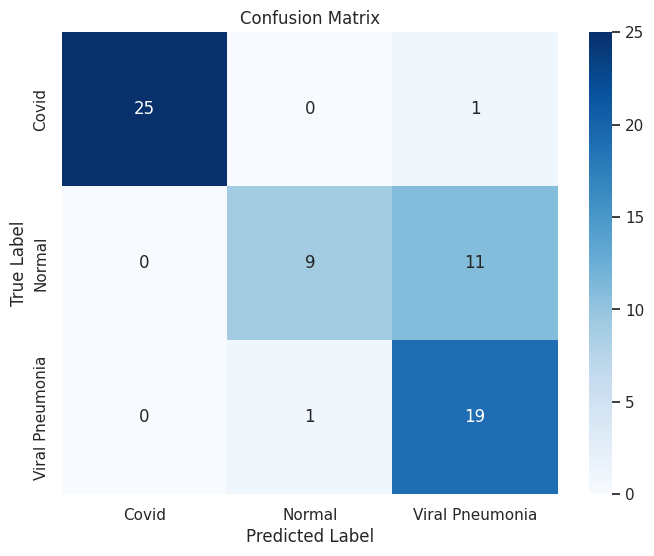

In [22]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


The model performs well in detecting "Covid," correctly identifying 25 out of 26 cases with only 1 misclassification.
For "Normal" cases, 9 are correctly classified, but 11 are misclassified as "Viral Pneumonia," indicating a challenge in distinguishing these two categories.
"Viral Pneumonia" detection is strong, with 19 correctly identified and only 1 misclassified as "Normal." This highlights the need to improve the differentiation between "Normal" and "Viral Pneumonia" while maintaining the strong performance in detecting "Covid."

# **API Development for Deployment**

For the next step, let's proceed to make the model available for use by healthcare providers. We'll develop a user-friendly interface using either Gradio or Streamlit to serve the model. This interface will allow healthcare providers to upload chest X-ray images and receive the model's predictions in an easy-to-use web format

In [23]:
#install gradio

#!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Load the trained model
model_path = '/content/covid_classification_model.h5'
try:
    model = load_model(model_path)
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at path: {model_path}")
    raise

# Compile the model to ensure metrics are loaded
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the prediction function
def predict_image(img):
    try:
        # Ensure that the image is a PIL image
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        # Resize the image using PIL's resize method to the model's input size
        img = img.resize((150, 150))

        # Convert the image to an array
        img_array = np.array(img) / 255.0  # Normalize the image to match training preprocessing
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make the prediction
        prediction = model.predict(img_array)

        # Map the prediction to a class name
        class_names = ['Covid', 'Normal', 'Viral Pneumonia']
        predicted_class = class_names[np.argmax(prediction)]

        return predicted_class
    except Exception as e:
        # Return the error message in case of an issue
        return f"Error: {str(e)}"

# Create the Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs="image",
    outputs="text",
    title="COVID-19 Chest X-Ray Classification",
    description="Upload a chest X-ray image to determine if it indicates Covid, Normal, or Viral Pneumonia."
)

# Launch the interface
interface.launch(debug=True)


Model loaded successfully.
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://034272bd95b6665fb4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


# **Analysis and Recommendations**

**Analysis**

The model demonstrates excellent performance in detecting "Covid" cases, achieving high precision (1.0), recall (0.96), and an F1-score of 0.98. However, it struggles with distinguishing "Normal" and "Viral Pneumonia," with 9 "Normal" samples correctly classified and 11 misclassified as "Viral Pneumonia." Similarly, 19 "Viral Pneumonia" samples are correctly classified, but 1 is misclassified as "Normal." These misclassifications likely stem from overlapping features in chest X-rays of these conditions. The overall test accuracy is 80.3%, and while the model reliably detects "Covid," improvements are needed to enhance classification performance for the other classes.

**Recommendations**

Data Augmentation: Apply advanced augmentation techniques such as rotation, zoom, and flipping to increase data variability, particularly for "Normal" and "Viral Pneumonia" cases.
Collect More Data: Expand the dataset with additional samples for "Normal" and "Viral Pneumonia" to improve class differentiation.
Fine-Tune Layers: Unfreeze and fine-tune specific layers of the VGG16 model to enable better learning of dataset-specific features.
Revisit Class Weights: Adjust class weights to ensure balanced focus across all classes during training, particularly for underrepresented classes.
These steps can help the model improve its ability to classify "Normal" and "Viral Pneumonia" cases more accurately while maintaining strong performance in detecting "Covid."